In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.429441  0.612634  0.253143 -0.716502 -1.019338 -0.352461  0.683404   
  1   0.122019 -0.127298 -0.322523 -0.325443 -0.178916  0.887119 -0.247918   
  2  -0.400465  0.460224  0.642854 -0.310385  0.274817  0.718337  0.016354   
  3   1.239376  1.437685  0.142160  0.518173 -0.363721 -0.533131 -0.953228   
  4  -0.153192 -0.237530 -0.333559  0.221507  0.034869 -0.020118 -0.688328   
  5   0.168821  0.510306  0.931615 -0.407754  0.001930 -0.402696 -0.176637   
  6   0.005542 -0.656864 -0.259523 -0.074714 -0.781405  0.401773 -0.332142   
  7   0.801326  0.487526 -0.193052  0.056111  0.690679 -0.714159 -0.422680   
  8   0.125950 -0.158503  0.236283  0.368714  0.332202  1.163462 -0.288895   
  9  -0.151408  0.080984  0.924149  1.020938  0.786194  0.433992  0.171484   
  10  0.796841  1.339116 -0.253057 -0.588338 -0.345738 -0.063741 -0.772279   
  11  0.805231 -0.362605  0.319515 -0.444419  0.342601  0.538547 -0.278363   
  12 -0.308821  1.421194  0.808025 -0.689760 -0.293808  0.855118 -0.682432   
  13  0.527907  0.153536  0.298370  0.010990  0.594814  0.986184  1.066248   
  14  0.751415  0.541635  0.029787  0.006982  0.108897  0.394221 -0.509688   
  15  0.101831 -0.419077 -0.401150  0.171278 -0.207444  0.326039 -0.204957   
  16  0.318314  0.554686  0.320754 -0.059569  1.153757 -0.086388 -0.393105   
  17  0.833174  0.997415  0.926830 -0.156204  0.459453  0.466689 -0.455344   
  18 -0.165519 -0.870390  0.904845  0.280953  0.491160 -0.140335 -0.349938   
  19 -0.027843 -0.550659  0.051790  0.603066 -0.015093  1.467297  0.935939   
  20  0.666249 -0.868662  0.746717  0.642762 -0.201663 -0.663415 -0.054493   
  21  0.695162 -0.534230  0.355588  0.292132  0.264358 -0.319365 -0.503323   
  22 -0.734658  0.031507 -0.440485  0.803276  0.867010  0.658304 -0.618908   
  23 -0.337964 -0.486866 -0.156683  1.063441 -0.155767 -0.642924 -0.276177   
  24  0.100566  0.603631  0.492102  0.134209  0.022923 -0.192333  0.246606   
1 0   0.588861 -0.904055  0.380006 -0.363541 -0.631375 -0.262619 -0.336716   
  1   0.360686 -0.538555 -1.217481 -0.028879  0.467208  0.481321  0.493433   
  2  -0.363540 -1.156149 -0.688108 -1.023678  0.114200  0.058712 -0.255251   
  3   0.143086 -0.695714  0.332143 -0.425398 -0.182627  0.159017  1.051284   
  4  -0.382570  0.113212  0.725014 -0.742780  0.225302 -0.245291 -0.184646   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.355929 -0.500572 -0.025932  ...  1.192139 -0.735457  0.108365   
  1   0.461642 -0.285346 -0.076765  ...  0.537567  0.285234  0.061588   
  2  -0.027381 -0.463507  0.271864  ...  0.950256  0.051059 -0.278293   
  3   0.499263  0.354672  0.665169  ... -0.848790  0.334092 -1.294055   
  4  -0.747628 -0.351665 -0.076845  ... -0.482879  0.026731  0.356676   
  5  -0.010284  0.483606  0.272566  ...  0.565508  0.737234  0.668399   
  6  -0.300358 -0.451280 -0.527775  ...  1.347841 -0.097896  0.282731   
  7  -0.329970 -0.890673  0.562015  ...  0.303528 -0.216233 -0.716128   
  8  -0.306393  0.910120  0.472279  ...  1.427422  0.861732  0.263966   
  9  -0.428861 -0.125703  0.417912  ...  0.295086 -0.987689 -0.420679   
  10  0.005702 -0.332907  1.459238  ...  0.034378  0.390760  0.217767   
  11  0.124649 -0.177900  0.725155  ...  0.277116  0.484296 -1.049526   
  12 -0.752295  0.113529  0.417604  ...  0.259576 -1.016574 -0.413540   
  13  0.062425 -0.215367 -0.105302  ... -0.444822 -1.273558 -0.823491   
  14 -0.395720 -0.617772 -0.029183  ...  0.177159 -0.093094  0.152346   
  15 -0.481801  0.464743  0.265948  ...  0.257661  1.129826  0.217162   
  16  0.271106  0.214581 -0.746519  ...  0.010729  0.310098  1.100432   
  17 -1.042607 -0.181005  1.082750  ...  0.016435  0.569566  0.318645   
  18 -0.203351 -0.369584 -0.324013  ... -0.628235  0.219895  0.102868   
  19 -1.084214 -0.444253 -1.496490  ... -0.176153 -0.665315 -0.382290   
  20  0.124175 -0.103425 -0.560850  ...  0.177565 -0.156787 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.058537  0.040292  26.271352  4.076572e-152  0.979566  1.137509


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



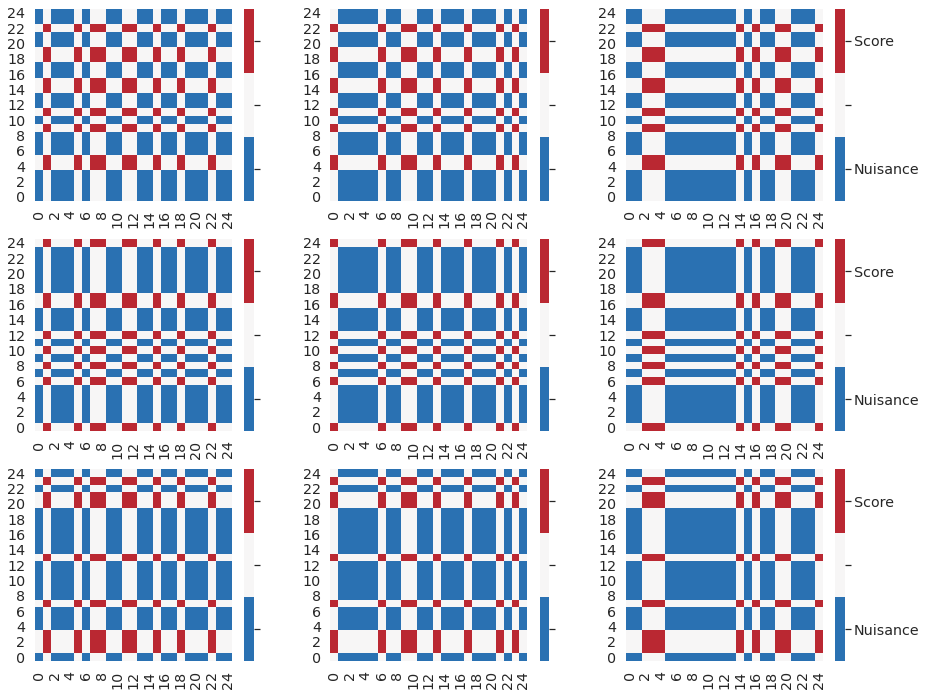

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



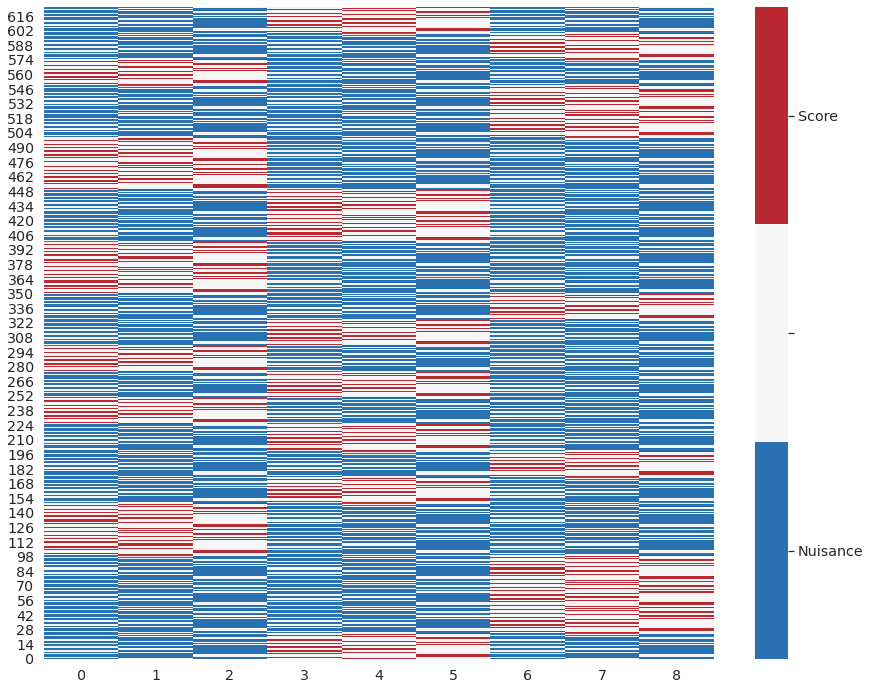

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])